# Understanding Fourier Transform

## Generate a sine
### Properties
* Sampling rate (Hz) = points per second
* Main frequency (Hz) = cycle per second
* Duration (seconds)
* Number of sample = sampling rate * duration = X time points
* Amplitude (Volts) = the max values of the sin
* Phase (degrees)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
Fs = 8
f = 1 
duration = 2
amplitude = 10
phi = 30
N = Fs * duration # Total number of discrete samples
t = np.arange(N) # Time vector
# Construct a pure sine wave
y = amplitude * np.sin(2 * np.pi * f * (t/Fs) + np.deg2rad(phi))

Let's now plot the signal in the ***time-domain***

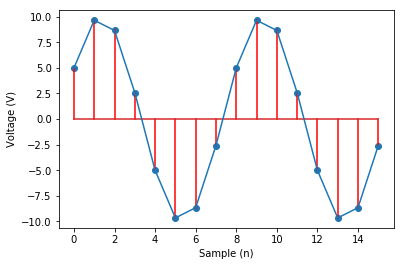

In [2]:
# Plot the sine in the time-domain
plt.stem(t,y, 'r')
plt.plot(t,y)
plt.xlabel('Sample (n)')
plt.ylabel('Voltage (V)')
plt.show()

## Compute the Discrete Fourier Transform manually
We will use Euler's formula to convert the exponential terms in sin and cos:
e<sup>jx</sup> = cos x + j sin x

In [3]:
def DFT_naive(x):
    '''Implementation of the Discrete Fourier Transform using a naive 
    and ultra-slow method based on Euler's formula. 
    See https://www.youtube.com/watch?v=mkGsMWi_j4Q
    '''
    N = x.shape[0]
    
    # The number of frequency bins = the number of samples
    dft = np.zeros(N, dtype=complex)
    
    for k in np.arange(N):
        dft[k] = np.sum([n*(np.cos(-2*np.pi*i*k/N) + 1j * np.sin(-2*np.pi*i*k/N)) for i, n in enumerate(x)])
        
    return dft

In [4]:
dft = DFT_naive(y)
print(dft)

[ 1.11022302e-14+0.00000000e+00j -3.77172762e-14+8.10462808e-15j
  4.00000000e+01-6.92820323e+01j  7.01450732e-15-4.13002965e-14j
  2.16880710e-14+4.90163183e-15j  1.11427413e-14-8.88178420e-15j
  2.04281037e-14-3.55271368e-15j -5.26146735e-14-5.16253706e-14j
  1.19904087e-14-3.57007290e-14j  2.11449530e-14+4.67403893e-14j
  6.39488462e-14+8.88178420e-14j -3.41951757e-14+2.04281037e-14j
 -4.68824394e-14-5.92644084e-14j  4.53580193e-14+6.79456491e-14j
  4.00000000e+01+6.92820323e+01j  1.07459078e-13-5.88418203e-14j]


The units of the FFT is the same as the original signal, i.e. in Volts. 

The resulting spectrum is two-sided. However, because of the Nyquist theorem, we cannot compute the DFT for frequency > Fs / 2. Therefore we split the spectrum in two.

NumPy doc:
> When the DFT is computed for purely real input, the output is Hermitian-symmetric, i.e. the negative frequency terms are just the complex conjugates of the corresponding positive-frequency terms, and the negative-frequency terms are therefore redundant. This function does not compute the negative frequency terms, and the length of the transformed axis of the output is therefore n//2 + 1.

In [5]:
# We keep only the first half
dft = dft[0:N//2+1]

# Round for visualization purpose
dft = np.round(dft, 4)
print(dft)

[ 0. +0.   j -0. +0.   j 40.-69.282j  0. -0.   j  0. +0.   j  0. -0.   j
  0. -0.   j -0. -0.   j  0. -0.   j]


We can now compute the frequency vector. Because we have 16 sample points (Fs * duration), we get 16 frequency bins from 0 to Fs-1. That means that the more sample points you have, the more frequency bins you get and the higher the resolution of the DFT is. Again, because our input data are real, we split the frequency vector in two to remove the redundant negative-frequency terms.

In [6]:
freqs = np.linspace(0, Fs, N, endpoint=False)
freqs = freqs[0:N//2+1]
print(freqs)

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]


Let's compare our values with the NumPy FFT built-in function

In [7]:
fft_np = np.fft.rfft(y)
freqs_np = np.fft.rfftfreq(N, d=1./Fs)

# Round for visualization purpose
fft_np = np.round(fft_np, 4)
print(dft, fft_np)

# Compare our method and NumPy
print(np.allclose(dft, fft_np))
print(np.allclose(freqs, freqs_np))

[ 0. +0.   j -0. +0.   j 40.-69.282j  0. -0.   j  0. +0.   j  0. -0.   j
  0. -0.   j -0. -0.   j  0. -0.   j] [ 0. +0.   j -0. +0.   j 40.-69.282j  0. -0.   j  0. +0.   j -0. -0.   j
  0. -0.   j  0. +0.   j  0. +0.   j]
True
True


***Note: the complexity of the Discrete Fourier Transform is equals to N<sup>2</sup>***

In [8]:
print('The number of operations performed is: ' + str(N**2))

The number of operations performed is: 256


### Extract the magnitude and power spectral density
The magnitude is the square root of a<sup>2</sup> + b<sup>2</sup> divided by the number of samples. The resulting values are in Volts / Hz.

In [9]:
mag =  np.sqrt(dft.real**2 + dft.imag**2) / N # or np.abs(dft) / N
print(mag)

[0.         0.         4.99999825 0.         0.         0.
 0.         0.         0.        ]


Let's plot the result of a DFT. In other words, we are now looking at the signal y in the ***frequency-domain***.

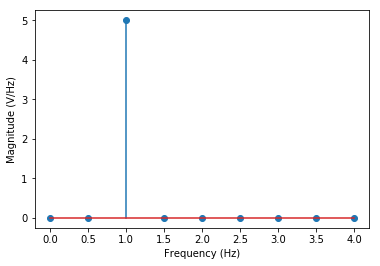

In [10]:
plt.stem(freqs, mag)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (V/Hz)')
plt.show()

More often, we want to compute the power spectral density, expressed in Volts<sup>2</sup>/Hz

In [11]:
# Now compute the one-sided Power Spectral Density
onesided = True
fac = 2 if onesided == True else 1
psd = (fac * mag) ** 2
print(np.round(psd, 2))

[  0.   0. 100.   0.   0.   0.   0.   0.   0.]


Check that we obtain the same values that with Scipy built-in function to compute PSD (periodogram)

In [12]:
from scipy.signal import periodogram
freqs_scipy, psd_den_scipy = periodogram(y, Fs, scaling='density')
print(np.round(psd_den_scipy, 2))

[  0.   0. 100.   0.   0.   0.   0.   0.   0.]


To compute the Power Spectrum, we divide by the duration in seconds of the recordings. The resulting values are in V<sup>2</sup>)

In [13]:
spec = psd / duration
print(spec)
_, psd_spec_scipy = periodogram(y, Fs, scaling='spectrum')
print(np.round(psd_spec_scipy, 2))
print(np.allclose(psd_spec_scipy, spec))

[ 0.          0.         49.99996503  0.          0.          0.
  0.          0.          0.        ]
[ 0.  0. 50.  0.  0.  0.  0.  0.  0.]
True


Because powers can get really big, it can be useful to scale them using a log-transform. PSD can be converted to dB using the formula dB = 10 * log<sub>10</sub>(powers). The scaling does not affect the units which are still in Volts<sup>2</sup>/Hz.

In [14]:
# We only keep the non-zero values to avoid "RuntimeWarning: divide by zero encountered in log10"
db = 10 * np.log10(psd[psd != 0])
print(db)

[19.99999696]


### Extract the phase angle

To extract the angle (= phase), we use the **arctangent** function.

*From https://www.gaussianwaves.com/2015/11/interpreting-fft-results-obtaining-magnitude-and-phase-information/*
> The obvious choice for implementation seems to be the *arctan* function in Numpy. However, usage of atan function will prove disastrous unless additional precautions are taken. The atan function computes the inverse tangent over two quadrants only, i.e, it will return values only in the [−π/2,π/2] interval. Therefore, the phase need to be unwrapped properly. We can simply fix this issue by computing the inverse tangent over all the four quadrants using the *arctan2(Ximg,Xre)* function.

In [15]:
# Return the angle in radiant of the complex DFT values
phases = np.angle(dft) # same as np.arctan2(dft.imag, dft.real)
print(phases)

# However the phase returned by np.angle() is based on the cosine. 
# To find the phase of the sine function:
sin_phases = np.cos(phases)
print(np.rad2deg(sin_phases))

[ 0.          3.14159265 -1.04719735 -0.          0.         -0.
 -0.         -3.14159265 -0.        ]
[ 57.29577951 -57.29577951  28.64789977  57.29577951  57.29577951
  57.29577951  57.29577951 -57.29577951  57.29577951]


We obtain a phase of 28.64 degrees at the frequency f = 1 Hz. This is probably due to rounding.

Now let's plot the estimated phases.

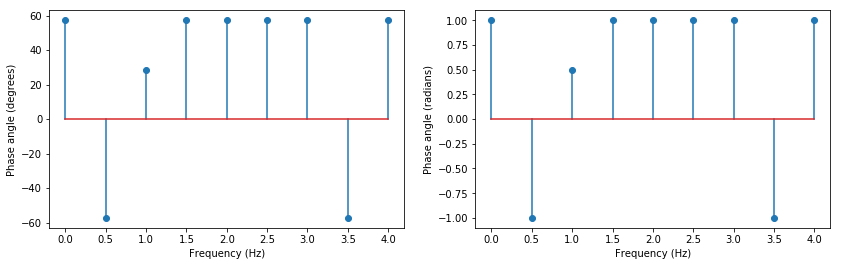

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharex=True)
ax1.stem(freqs, np.rad2deg(sin_phases))
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Phase angle (degrees)')
ax2.stem(freqs, sin_phases)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase angle (radians)')
plt.show()

# Appendix

## Working with more complex signals

The number of operations performed is: 16384


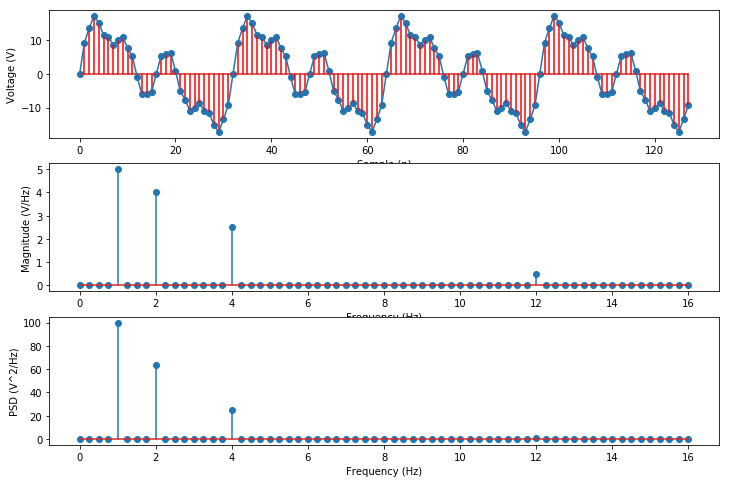

In [17]:
Fs = 32 
f = [1, 2, 4, 12]
A = [10, 8, 5, 1]
duration = 4
N = Fs * duration
t = np.arange(N)
w = 2 * np.pi * t / Fs

# Construct a mixed sine wave
y = A[0] * np.sin(w * f[0]) + A[1] * np.sin(w * f[1]) + A[2] * np.sin(w * f[2]) \
  + A[3] * np.sin(w * f[3])
dft = np.zeros(N, dtype=complex)

# Complexity
print('The number of operations performed is: ' + str(N**2))

# Compute DFT
dft = DFT_naive(y)

dft = dft[0:N//2+1]

# Compute freqs vector
freqs = np.linspace(0, Fs, N, endpoint=False)
freqs = freqs[0:N//2+1]

# Magnitude and PSD
mag = np.abs(dft) / N
psd = (2 * mag) ** 2

# Plot the signal in time and frequency domain
f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 8))
ax1.stem(t, y, 'r')
ax1.plot(t,y)
ax1.set_xlabel('Sample (n)')
ax1.set_ylabel('Voltage (V)')
ax2.stem(freqs, mag)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Magnitude (V/Hz)')
ax3.stem(freqs, psd)
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('PSD (V^2/Hz)')
plt.show()

## DFT using matrix multiplication

In [18]:
def DFT_matrix(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

In [19]:
Fs = 8
f = 1
duration = 1
N = Fs * duration
t = np.arange(N)
y = np.sin(2 * np.pi * f * t / Fs)

# Check by comparing with NumPy built-in function
print(np.allclose(DFT_matrix(y), np.fft.fft(y)))

True


## The Fast Fourier Transform
Thanks to: http://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/

In [20]:
def FFT(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif N <= 32:  # this cutoff should be optimized
        return DFT_matrix(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N // 2] * X_odd,
                               X_even + factor[N // 2:] * X_odd])

In [21]:
Fs = 64
f = 1
duration = 4
N = Fs * duration
t = np.arange(N)
y = np.sin(2 * np.pi * f * t / Fs)

print('DFT: ' + str(N**2) + ' operations')
print('FFT: ' + str(N*np.log2(N)) + ' operations')

# Compute FFT
fft = FFT(y)

# Check by comparing with NumPy built-in function
print(np.allclose(fft, np.fft.fft(y)))

DFT: 65536 operations
FFT: 2048.0 operations
True


## Time comparison between the three algorithms

In [22]:
%timeit DFT_naive(y)
%timeit DFT_matrix(y)
%timeit np.fft.fft(y)

526 ms ± 6.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.59 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.82 µs ± 101 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## The Inverse Fourier Transform

In [23]:
Fs = 8
f = 1
duration = 1
N = Fs * duration
t = np.arange(N)

y = np.sin(2 * np.pi * f * t / Fs)
dft = np.zeros(N, dtype=complex)
idft = np.zeros(N, dtype=complex)

# Compute DFT
dft = DFT_naive(y)

# Compute iDFT
for k in np.arange(N):
    idft[k] = np.sum([n*(np.cos(2*np.pi*i*k/N)+1j*np.sin(2*np.pi*i*k/N)) for i, n in enumerate(dft)])
    
reconstructed_signal = idft.real / N

print(np.round(y, 2))
print(np.round(reconstructed_signal, 2))

[ 0.    0.71  1.    0.71  0.   -0.71 -1.   -0.71]
[ 0.    0.71  1.    0.71  0.   -0.71 -1.   -0.71]


## Bonus: computing cos and sin by hand using Taylor series

In [24]:
from scipy.special import factorial
        
def cos_taylor(r, n_iter=50):
    """Compute a cos of a angle in radian.
    n_iter = number of iterations"""   
    return np.sum(((-1)**n * (r**(2*n))) / factorial(2*n) for n in np.arange(0, n_iter))
    
def sin_taylor(r, n_iter=50):
    """Compute a cos of a angle in radian.
    n_iter = number of iterations"""   
    return np.sum(((-1)**(n-1) * (r**(2*n-1))) / factorial(2*n-1) for n in np.arange(1, n_iter))

print(cos_taylor(3.5), np.cos(3.5))
print(sin_taylor(3.5), np.sin(3.5))
print(np.allclose(cos_taylor(3.5), np.cos(3.5)))
print(np.allclose(sin_taylor(3.5), np.sin(3.5)))

-0.9364566872907963 -0.9364566872907963
-0.35078322768961956 -0.35078322768961984
True
True


In [25]:
%timeit cos_taylor(3.5, 50)
%timeit np.cos(3.5)

439 µs ± 7.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
485 ns ± 6.27 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


NumPy implementation of the cos function is roughly 1000 times faster than ours with n_iter = 50 and ~200 times faster with n_iter = 10.